### Práctica 1 - Predicción Energía Eólica
Autores:
- Miguel Domínguez Gómez - 100451258
- Eduardo Fernández Vega - 100472251  

Enlace al repositorio:
https://github.com/MiguelMHR/Practica1-PrediccionEnergia


### 0. Tabla de contenidos:
1. [Requisitos](#1.-Requisitos)
2. [Lectura](#2.-Lectura)
3. [EDA](#3.-EDA)
4. [Evaluación inner y outer](#4.-Evaluación-inner-y-outer) 
5. [Elección del mejor escalador](#5.-Elección-del-mejor-escalador)

### 1. Requisitos

Importamos las librerías necesarias para el proyecto

In [28]:
# Importando las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, KFold, TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from joblib import dump


### 2. Lectura

Procedemos a leer el dataset usando la librería Pandas

In [29]:
# Leemos el dataset
wind_ava = pd.read_csv('./data/wind_ava.csv')

### 3. EDA

En esta sección se hará un análisis exploratorio de datos siguiento las cuestiones expuestas en el enunciado de la práctica

#### 3.0 Preparación previa del dataset
Como se expone en el punto **importante** de la práctica, debemos, antes de realizar el EDA simplificado, una limpieza de las columnas que no sean importantes. Las únicas que son relevantes son aquellas que tienen que ver con Sotavento:
- **datetime**
- **energy**
- solo aquellas que tengan un ".13" al final (**p54.162.13, p55.162.13, cape.13, etc**)

In [30]:
# Para quedarme solo con las columnas que terminan por ".13" o que sean "energy" o "datetime"
columnas_a_mantener = [columna for columna in wind_ava.columns if columna.endswith('.13') or columna == 'energy' or columna == 'datetime']
wind_ava = wind_ava[columnas_a_mantener]
print(wind_ava.head(1))


              datetime  energy    p54.162.13  p55.162.13    cape.13  \
0  2005-01-02 18:00:00  402.71  2.510824e+06    9.186295  13.527577   

     p59.162.13  lai_lv.13  lai_hv.13   u10n.13   v10n.13  ...      t2m.13  \
0  1.386937e+06   2.344111   2.432983 -0.757587 -1.922799  ...  280.473098   

      stl2.13     stl3.13   iews.13  inss.13     stl4.13    fsr.13   flsr.13  \
0  281.042026  281.462478 -0.057958 -0.13865  284.684755  0.404731 -5.927092   

    u100.13   v100.13  
0 -1.780562 -4.443617  

[1 rows x 24 columns]


#### 3.1 Descripción general del dataset
Para poder conocer ciertas características relevantes del dataset, como el número de instancias (filas) y característas (columnas) procederemos a usar diferentes funciones de Pandas con el dataset transformado

In [31]:
# Descripción de parámetros generales -> count, mean, std, min, 25%, 50%, 75%, max
print(wind_ava.describe())

# Número de filas y columnas del dataset
print("\n")
print("Número de filas: ", wind_ava.shape[0])
print("Número de columnas: ", wind_ava.shape[1])
print("\n")

# Para saber el tipo de variable de cada columna
print(wind_ava.info())

            energy    p54.162.13   p55.162.13      cape.13    p59.162.13  \
count  4748.000000  4.748000e+03  4748.000000  4748.000000  4.748000e+03   
mean    693.126247  2.489477e+06    16.008810    31.166541  1.706692e+06   
std     665.531609  4.482599e+04     6.552216   121.758977  1.466953e+06   
min       0.010000  2.358748e+06     1.650268     0.000000  5.610341e+04   
25%     144.170000  2.458543e+06    11.203264     0.000000  6.563209e+05   
50%     465.305000  2.490478e+06    15.543441     1.004148  1.239176e+06   
75%    1089.375000  2.525134e+06    20.214077    14.143328  2.296548e+06   
max    2792.550000  2.580387e+06    39.230807  2311.662152  1.110694e+07   

         lai_lv.13    lai_hv.13      u10n.13      v10n.13         sp.13  ...  \
count  4748.000000  4748.000000  4748.000000  4748.000000   4748.000000  ...   
mean      2.815222     2.576284     0.386215     0.120528  97820.301287  ...   
std       0.397377     0.116434     3.100583     3.016766    713.689654  ..

Como se puede apreciar, no existen valores nulos ya que el número de filas (4748) coincide con la cuenta de los valores no-nulos de cada columna

#### 3.2 Valores faltantes

Como ya se ha visto en el anterior apartado, no existen valores nulos como tal. Para asegurarnos, haremos lo siguiente

In [32]:
# Para poder saber el número de valores faltantes:
print(wind_ava.isnull().sum())


datetime      0
energy        0
p54.162.13    0
p55.162.13    0
cape.13       0
p59.162.13    0
lai_lv.13     0
lai_hv.13     0
u10n.13       0
v10n.13       0
sp.13         0
stl1.13       0
u10.13        0
v10.13        0
t2m.13        0
stl2.13       0
stl3.13       0
iews.13       0
inss.13       0
stl4.13       0
fsr.13        0
flsr.13       0
u100.13       0
v100.13       0
dtype: int64


Ahora, comprobaremos, como todos son números decimales, si por casualidad hay algún cero que no tengan sentido en el dataset

In [33]:
# Ahora, comprobaremos, como todos son números decimales, si por casualidad hay algún cero que no tengan sentido en el dataset
# Para ello, veremos el número de ceros que hay en cada columna
print((wind_ava == 0).sum())

datetime         0
energy           0
p54.162.13       0
p55.162.13       0
cape.13       1492
p59.162.13       0
lai_lv.13        0
lai_hv.13        0
u10n.13          0
v10n.13          0
sp.13            0
stl1.13          0
u10.13           0
v10.13           0
t2m.13           0
stl2.13          0
stl3.13          0
iews.13          0
inss.13          0
stl4.13          0
fsr.13           0
flsr.13          0
u100.13          0
v100.13          0
dtype: int64


Se puede apreciar que en cape.13 hay bastantes valores que son cero pero, como esa variable tiene sentido que sea cero en determinados contextos, como en condiciones atmosféricas estables, se ha decidido mantener así

#### 3.3 Columnas constantes
En este apartado se evaluará qué columnas son constantes para todos sus valores

In [34]:
# Encontrar las columnas que tienen un solo valor único (columnas constantes)
constant_columns = wind_ava.columns[wind_ava.nunique() <= 1].tolist()
print(constant_columns)


[]


Como se puede apreciar, no existen columnas constantes, por lo que no se va a eliminar nada del dataset

#### 3.4 ¿Regresión o clasificación?
Directamente conociendo la naturaleza de la variable objetivo, la energía, se puede saber ante qué tipo de problema nos enfrentamos. Como la energía es una variable continua, nos encontramos ante un problema de regresión. 


#### 3.5 Otras consideraciones: outliers
Otro apartado del EDA que no se menciona en el enunciado y que creemos que es de vital importancia para realizar un buen análisis exploratorio es evaluar los valores lejanos, o outliers

#### 3.5.1 Outliers con Histograma

Usaremos varios métodos de representación de los datos para poder observar los valores alejados

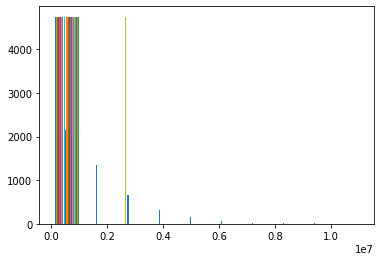

In [35]:

# Quitamos 'datetime' al no ser una columna numérica
columna_excluida = 'datetime'
plt.hist(wind_ava[wind_ava.columns.difference([columna_excluida])])
plt.show()

Se puede apreciar que hay ciertos valores que se salen de la norma, aunque se verá más claro realizando los boxplots

##### 3.5.2 Outliers con Boxplot
Para poder evaluar atributo a atributo, se procederá a hacer un boxplot de los 21 atributos (menos datetime, al no ser numérico y no tener outliers al ser un registro de las mediciones diarias)

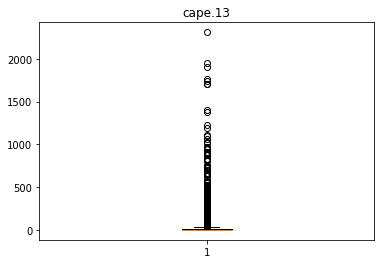

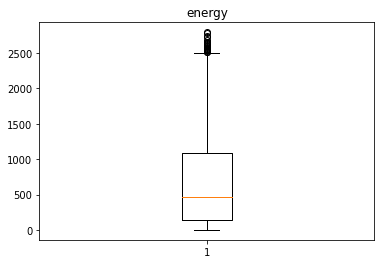

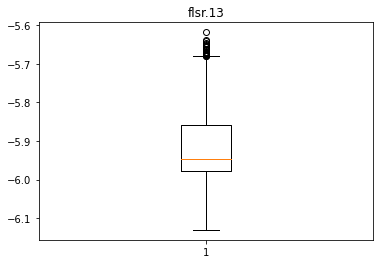

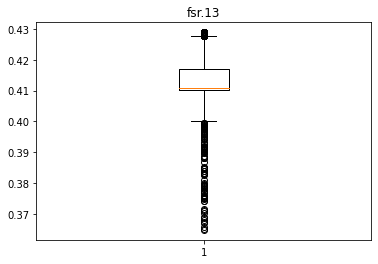

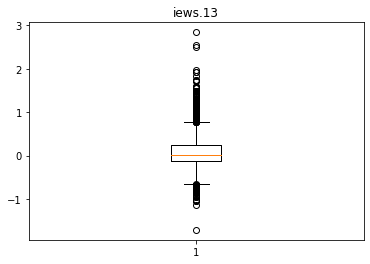

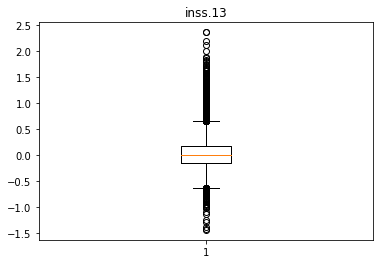

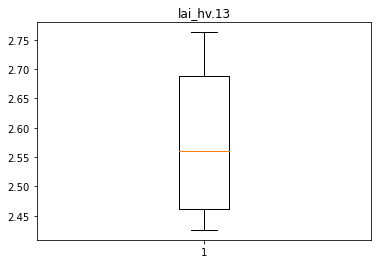

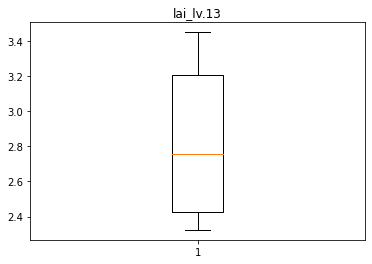

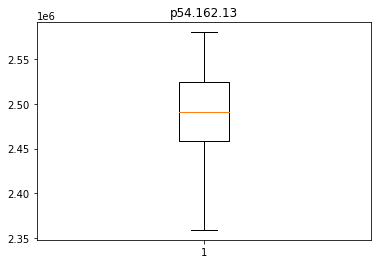

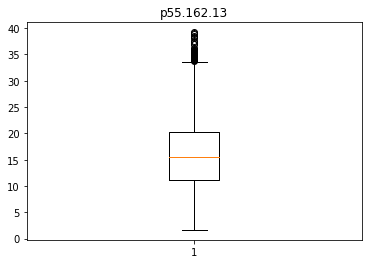

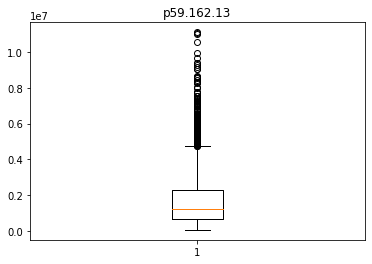

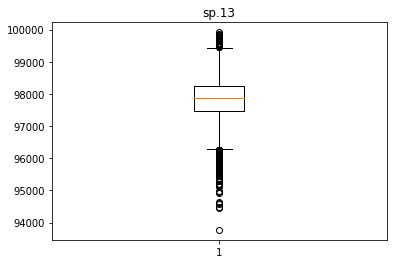

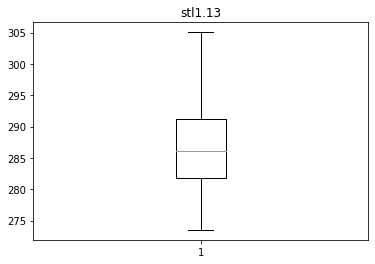

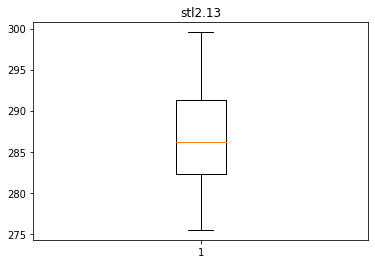

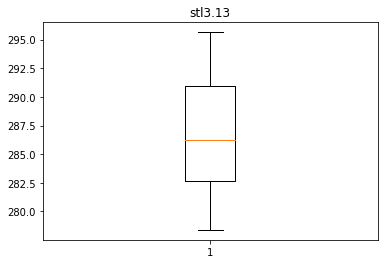

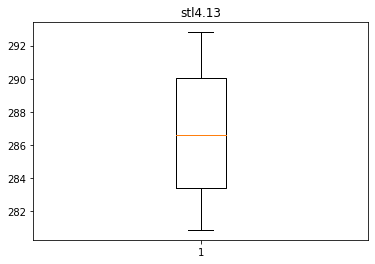

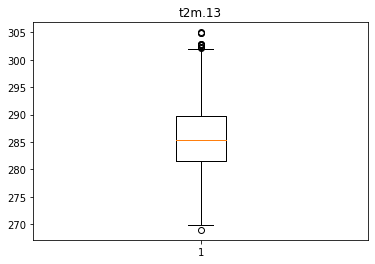

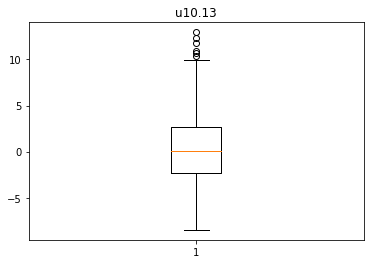

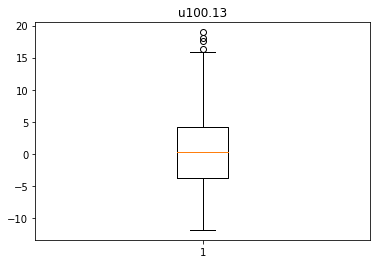

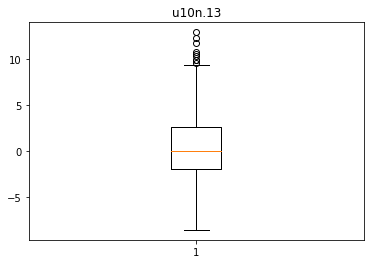

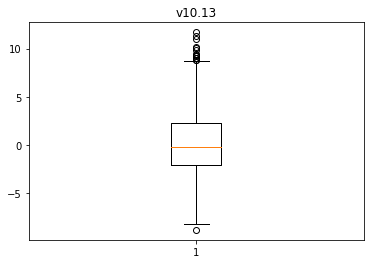

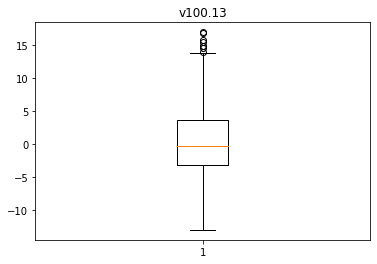

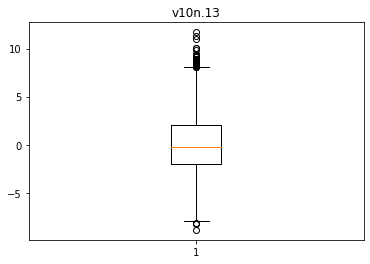

In [36]:
# Boxplot para cada atributo y sacamos los outliers de cada uno
outliers = []
for attribute in wind_ava.columns.difference([columna_excluida]):
    plt.boxplot(wind_ava[attribute])
    plt.title(attribute)
    plt.show()
    Q1 = wind_ava[attribute].quantile(0.25)
    Q3 = wind_ava[attribute].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers.append(wind_ava[(wind_ava[attribute] < lower_bound) | (wind_ava[attribute] > upper_bound)].index)

Como muestran los resultados, hay ciertos atributos que poseen bastantes outliers, otros que poseen algunos y hay otros atributos en los que es inexistente. Hace falta determinar si esos son ruido, para ser eliminados en futuros modelos para mejorar la predicción, o si son datos realmente significativos para el dataset. Al ser variables meteorológicas, cabe la posibilidad de que haya cierto fallo en la medición, pero al ser la metereología de una región algo tan cambiante, se cree que esa información debe prevalecer en el dataset, a pesar de poseer outliers

### 4. Evaluación inner y outer

En este apartado se va a describir el proceso seguido para realizar tanto la evaluación inner como la outer:

Se ha decidido dividir el dataset en **train** y **test** de la siguiente forma, siguiendo el criterio, no exactamente, de *2/3 para train* y *1/3* *para* *test*:

* *train:* 2005 al 2007 (**60%**)
* *test:* 2008 y 2009 (**40%**)

No se ha decidido añadir aleatoriedad a la selección de instancias a las particiones *train* y *test* ya que hay dependencia temporal en los datos. Es decir, no se pueden mezclar datos del 2005 con datos del 2009 ya que podrían afectar al aprendizaje del modelo. 

No se ha decidido seguir al 100% *2/3 para train* y *1/3* *para test* al querer dividir las particiones por años exactos.



Por otro lado, dentro del *train*, se va a realizar un **ajuste de hiperparámetros** para la evaluacion inner, dividiendo *train*, siguiendo TimeSeriesSplit, de la siguiente forma:

* **Prueba #1**:
  * *train_train:* 2005
  * *train_validation: 2006*
* **Prueba #2:**
  * *train_train:* 2005 y 2006
  * *train_validation:* 2007

Se ha decidido usar TimeSeriesSplit para dividir *train* por la misma razón por la que no añadiamos aleatoriedad a la selección de instancias. Al trabajar con datos con dependencia temporal, es mejor usar TimeSeriesSplit

Los hiperparámetros que se van a ajustar dependen del modelo a usar y se comentarán en el punto 4


Para la evaluación outer, se evaluará el rendimiento usando la partición *train* inicial y la partición *test* de 2008 y 2009, es decir, el dataset completo, usando los mejores hiperparámetros encontrados en la evaluación inner. 


Las **métricas** que se van a usar para evaluar el rendimiento a futuro van a ser:

* **RMSE :** muy recomendado como métrica de error
* **Tiempo de ejecución :** es una variable relevante para poder ofrecer un modelo que pueda ejecutar en un tiempo razonable. También, se usará como medio de desempate si hay modelos que tienen errores muy parecidos.

Aunque siempre se priorizará el modelo que tenga menos error, habrá una excepción. Si el tiempo de ejecución es infinitamente superior en uno de los dos modelos a comparar y poseen errores muy parecidos, se elegirá el que tenga menor tiempo de ejecución.


In [37]:
# ----  Selección inicial de X e Y  ----
# X -> Todas las columnas menos 'datetime' y 'energy'
# Y -> 'energy'
X = wind_ava.loc[:,columnas_a_mantener[2:]]
Y = wind_ava.energy

# ----  División del dataset en Train-Test:  ----
# Dividimos el dataset en entrenamiento del 2005 al 2007 y test del 2008 al 2009
X_train = X.loc[wind_ava.datetime < '2008-01-01']
X_test = X.loc[wind_ava.datetime >= '2008-01-01']
Y_train = Y.loc[wind_ava.datetime < '2008-01-01']
Y_test = Y.loc[wind_ava.datetime >= '2008-01-01']


### 5. Elección del mejor escalador
Para elegir el mejor escalador, se hará varias pruebas usando KNN por omisión con 3-Fold cross validation, una por cada scaler:
MinMax, Standard y Robust

In [38]:
"""
Si el método a usar posee random_state, usar 100451258 (mi NIA)
"""

# ----  Evaluación inner con 3-Fold CV  ----
inner = KFold(n_splits=3, shuffle=True, random_state=100451258)
# Diccionario para almacenar los resultados de la evaluación inner  ----
inner_scores = {}

# ----  1. KNN con StandardScaler  ----
# Creamos el pipeline
pipeline_std = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsRegressor())])
# Evaluación inner
scores_std = cross_val_score(pipeline_std, X_train, Y_train, cv=inner, scoring='neg_root_mean_squared_error')
inner_scores['KNN con StandardScaler'] = -scores_std.mean()

# ----  2. KNN con MinMaxScaler  ----
# Creamos el pipeline
pipeline_mm = Pipeline([('scaler', MinMaxScaler()), ('knn', KNeighborsRegressor())])
# Evaluación inner
scores_mm = cross_val_score(pipeline_mm, X_train, Y_train, cv=inner, scoring='neg_root_mean_squared_error')
inner_scores['KNN con MinMaxScaler'] = -scores_mm.mean()

# ----  3. KNN con RobustScaler  ----
# Creamos el pipeline
pipeline_rb = Pipeline([('scaler', RobustScaler()), ('knn', KNeighborsRegressor())])
# Evaluación inner
scores_rb = cross_val_score(pipeline_rb, X_train, Y_train, cv=inner, scoring='neg_root_mean_squared_error')
inner_scores['KNN con RobustScaler'] = -scores_rb.mean()

# ----  RESULTADOS FINALES  ----
for name, score in inner_scores.items():
    print(f"{name}: {score}")




KNN con StandardScaler: 406.6239774017178
KNN con MinMaxScaler: 417.2689336852763
KNN con RobustScaler: 412.4465910589574


Como se puede apreciar, el mejor scaler y el que usaremos de ahora en adelante es StandardScaler

### 6. Evaluación de los modelos

### Notas a cerca de cómo evaluar modelos

In [39]:
# Usaremos árboles de decisión con HPO y time series split
# inner: time series split 2005-2007 -> 3 splits

# 1. Definición del proceso de HPO 
# Seleccion posibles hiperparámetros para un árbol de decisión
param_grid = {
    'max_depth': range(2,16),
    'min_samples_split': range(2,16)
}

# evaluación inner con time series split
inner = TimeSeriesSplit(n_splits=3)

# Definición del proceso de HPO con GridSearchCV
# GridSearchCV es un método de búsqueda de hiperparámetros que evalúa todas las combinaciones posibles
# Si fuesen muchas pruebas de hiperparámetros, se puede usar RandomizedSearchCV, que solo coge algunas aleatorias, aunque funciona muy bien
regr = DecisionTreeRegressor(random_state=100451258)
gs_regr = GridSearchCV(regr, 
                       param_grid, 
                       cv=inner, 
                       scoring='neg_mean_squared_error', 
                       n_jobs=-1,
                       verbose=0)

# 2. Entrenamiento con la partición de entrenamiento
gs_regr.fit(X_train, Y_train)
# ahora gs_regr es un modelo

# 3. Evaluación outer del modelo con test -> estimacion del rendimiento futuro
Y_pred = gs_regr.predict(X_test)
mse = metrics.mean_squared_error(Y_test, Y_pred)
print("RMSE: ", np.sqrt(mse))

# 4. Obtener el modelo final
best_hyperparams = gs_regr.best_params_
print("Mejores hiperparámetros: ", best_hyperparams)
# Volvemos a hacer cross_validation pero con todos los datos
regr_final = gs_regr.fit(X, Y)
# Si hacemos esto, estaríamos pillando los hiperparámetros calculados en el inner evaluation
# y no los que se han calculado en el outer evaluation
# Se puede hacer, pero es más recomendable obtener el modelo final con un nuevo cross-validation
# ---> regr_final = DecisionTreeRegressor(**best_hyperparams)
# ---> regr_final.fit(X, Y)



RMSE:  443.1564635736528
Mejores hiperparámetros:  {'max_depth': 5, 'min_samples_split': 14}


In [56]:
param_grid = {'knn__n_neighbors': list(range(2,16)),
              'knn__p': [1,2],
              'knn__weights': ['uniform', 'distance'],
              'knn__leaf_size': list(range(1, 50))
              }

inner = KFold(n_splits=3, shuffle=True, random_state=42)

# Create a pipeline that scales the data and trains the model

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor())]
)

# Definition of a 2-step process that self-adjusts 2 hyperpars
regr = RandomizedSearchCV(pipe,
                   param_grid,
                   scoring='neg_mean_squared_error',
                   cv=inner,
                   n_jobs=1, verbose=1)

np.random.seed(42)

regr.fit(X=X_train, y=Y_train)

params_a_usar = regr.best_params_

print(params_a_usar)
print(-regr.best_score_)

modelo_final = regr.best_estimator_

modelo_final.fit(X=X, y=Y)



Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'knn__weights': 'distance', 'knn__p': 1, 'knn__n_neighbors': 12, 'knn__leaf_size': 39}
149644.26058843787


Pipeline(steps=[('scaler', StandardScaler()),
                ('knn',
                 KNeighborsRegressor(leaf_size=39, n_neighbors=12, p=1,
                                     weights='distance'))])

#### 6.1 Almacenamiento del modelo
    
Ahora almacenamos el modelo obtenido en un archivo modelo_final.plk

In [57]:
local_path = './modelo_final.plk'
dump(modelo_final, local_path)

['./modelo_final.plk']